In [339]:
from astropy.stats import sigma_clipped_stats
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.modeling import models, fitting
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats
import photutils
import math
import astroalign as asa
from statistics import mean

In [340]:
magnitude = 7.2
C = 299792458*10**10 #in Angstrom
lamb = 5500 #in Angstrom

In [341]:
f_freq = 3631*10**(-23)*10**(-magnitude/2.5)
f_lambda = f_freq*C/lamb**2
f_lambda #erg/A*s*cm2

4.743747592735647e-12

In [342]:
calibration = 15.28
#electrons per second on each pixel
print("estimated count per second:",10**calibration * f_lambda)

estimated count per second: 9039.024693890478


In [343]:
#Example of how to open a file
bias0 = fits.open("./dataM103/bias_000bias.fit")
print(bias0.info(),'\n'*2)
print(bias0[0].data)


Filename: ./dataM103/bias_000bias.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (4499, 3599)   int16 (rescales to uint16)   
None 


[[343 407 383 ... 343 375 388]
 [362 373 388 ... 340 363 411]
 [346 355 351 ... 403 379 392]
 ...
 [382 358 397 ... 478 445 462]
 [378 352 355 ... 415 401 490]
 [381 407 402 ... 402 467 433]]


# Bias

In [344]:
files_bias = glob.glob("./dataM103/*bias*.fit")

In [345]:
#plt.imshow(bias0[0].data,vmin=0,vmax=100)

In [346]:
def stacking(files,normalize=False,unbias=False):
    allpic=[]
    npic=0
    for ii, bb in enumerate(files) :
        mypic=fits.open(bb)
        allpic.append(mypic[0].data)
        mypic.close()
        npic+=1
    allpic=np.array(allpic)
    #print('Shape of stack', allpic.shape)
    meanval=np.mean(allpic, axis=0)
    if type(unbias) == np.ndarray:
        meanval = meanval - unbias
    if normalize:
        meanval = meanval/(np.mean(meanval))
    #print("Shape of array", meanval.shape)
    return meanval
    
meanbias = stacking(files_bias)
plt.clf()


<Figure size 640x480 with 0 Axes>

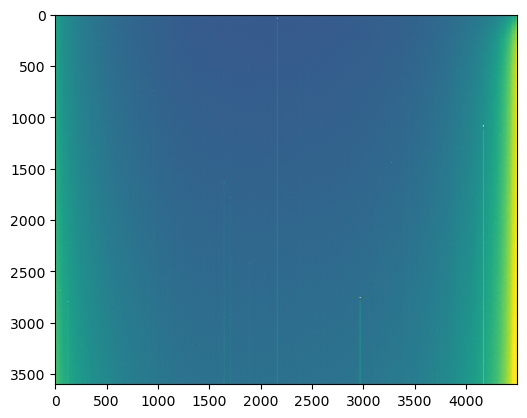

In [347]:
plt.imshow(meanbias,clim=[300,400])

In [348]:
# plt.hist(meanbias.flatten(),bins=30,density=False,log=True)

# Flat

In [349]:
files_flat_Ha = glob.glob("./dataM103/*flat*Ha.fit")
files_flat_OIII = glob.glob("./dataM103/*flat*OIII.fit")
files_flat_SII = glob.glob("./dataM103/*flat*SII.fit")

In [350]:
mean_flat_Ha = stacking(files_flat_Ha,unbias=meanbias,normalize=True)

In [351]:
#plt.hist(mean_flat_Ha.flatten(),bins=10,density=True,log=True)

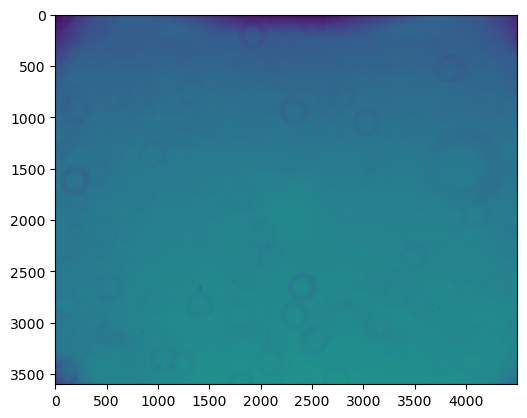

In [352]:
plt.imshow(mean_flat_Ha,clim=[0.8,1.3])

In [353]:
mean_flat_OIII = stacking(files_flat_OIII,unbias=meanbias,normalize=True)

In [354]:
# plt.hist(mean_flat_OIII.flatten(),bins=10,density=True,log=True)

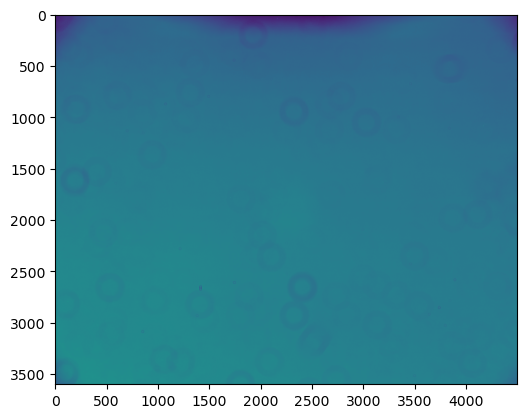

In [355]:
plt.imshow(mean_flat_OIII,clim=[0.8,1.3])

In [356]:
mean_flat_SII = stacking(files_flat_SII,unbias=meanbias,normalize=True)

In [357]:
# plt.hist(mean_flat_SII.flatten(),bins=10,density=True,log=True)

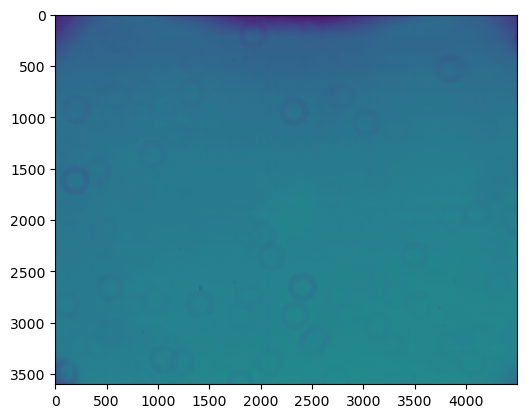

In [358]:
plt.imshow(mean_flat_SII,clim=[0.8,1.3])

# Data

In [359]:
data0 = fits.open("./dataM103/FSR0581_000Ha.fit")


In [360]:
data_files = glob.glob("./dataM103/M103*.fit")
calib_star = glob.glob("./dataM103/HD3360*.fit")

In [361]:
processed_images={}
for f in data_files:
    data = fits.open(f)
    if "Ha" in f:
        flat_data=mean_flat_Ha
    elif "OIII" in f:
        flat_data=mean_flat_OIII
    elif "SII" in f:
        flat_data=mean_flat_SII
    else:
        print('Cannot find filter type in image title')
    proc = (data[0].data-meanbias)/flat_data
    data.close()
    processed_images[f.split('/')[-1]]=proc*0.6

In [362]:
processed_calibration={}
for ca in calib_star:
    data = fits.open(ca)
    if "Ha" in ca:
        flat_data=mean_flat_Ha
    elif "OIII" in ca:
        flat_data=mean_flat_OIII
    elif "SII" in ca:
        flat_data=mean_flat_SII
    else:
        print('Cannot find filter type in image title')
    proc = (data[0].data-meanbias)/flat_data
    data.close()
    processed_calibration[ca.split('/')[-1]]=proc*0.6

In [363]:
processed_calibration.keys()

dict_keys(['HD3360_003Ha.fit', 'HD3360_003OIII.fit', 'HD3360_001Ha.fit', 'HD3360_002OIII.fit', 'HD3360_003SII.fit', 'HD3360_002Ha.fit', 'HD3360_001OIII.fit', 'HD3360_001SII.fit', 'HD3360_002SII.fit'])

In [364]:
processed_images.keys()

dict_keys(['M103_003OIII300s.fit', 'M103_003Ha300s.fit', 'M103_002Ha300s.fit', 'M103_002SII300s.fit', 'M103_004Ha300s.fit', 'M103_001SII300s.fit', 'M103_001Ha300s.fit', 'M103_002OIII300s.fit', 'M103_004SII300s.fit', 'M103_003SII300s.fit', 'M103_001OIII300s.fit', 'M103_004OIII300s.fit'])

## Dust on filters?

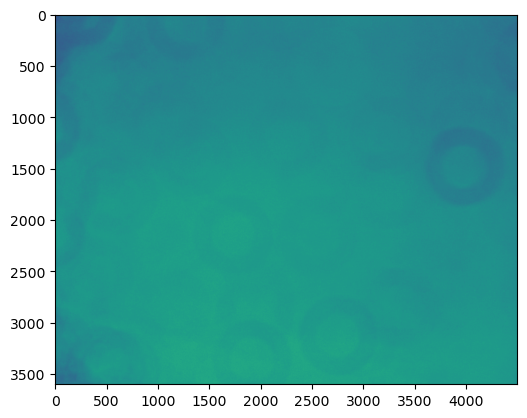

In [365]:
#Difference between filters
plt.imshow(mean_flat_Ha/mean_flat_SII,clim=[0.9,1.1])

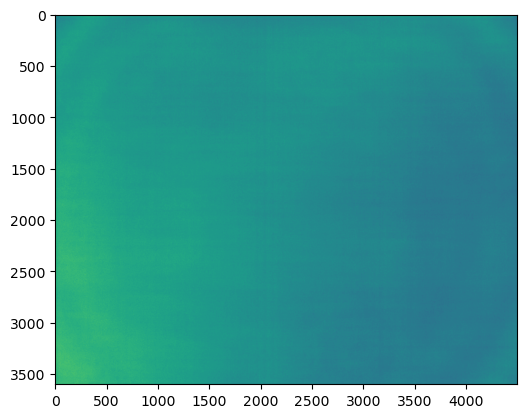

In [366]:
plt.imshow(mean_flat_OIII/mean_flat_SII,clim=[0.9,1.1])

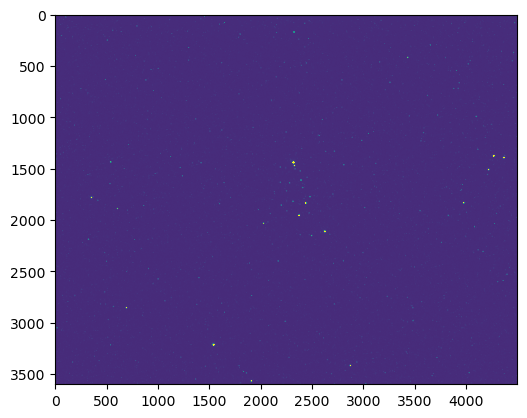

In [367]:
plt.imshow(processed_images['M103_003OIII300s.fit'],clim=[0,1000])

# Dark current

In [368]:
dark_files = glob.glob("./dataM103/*dark*.fit")

In [369]:
dark_files

['./dataM103/calib_044dark120.fit',
 './dataM103/calib_037dark60.fit',
 './dataM103/dark_008_60s.fit',
 './dataM103/dark_013_10s.fit',
 './dataM103/dark_003_10s.fit',
 './dataM103/dark_000_1s.fit',
 './dataM103/dark_012_1s.fit',
 './dataM103/dark_001_60s.fit',
 './dataM103/dark_011_60s.fit',
 './dataM103/calib_040dark60.fit',
 './dataM103/calib_037dark120.fit',
 './dataM103/dark_010_1s.fit',
 './dataM103/dark_002_1s.fit',
 './dataM103/dark_010_60s.fit',
 './dataM103/dark_000_60s.fit',
 './dataM103/calib_041dark120.fit',
 './dataM103/calib_046dark60.fit',
 './dataM103/dark_009_60s.fit',
 './dataM103/dark_002_10s.fit',
 './dataM103/dark_012_10s.fit',
 './dataM103/calib_038dark120.fit',
 './dataM103/dark_006_1s.fit',
 './dataM103/dark_014_1s.fit',
 './dataM103/dark_009_10s.fit',
 './dataM103/calib_036dark60.fit',
 './dataM103/dark_002_60s.fit',
 './dataM103/dark_012_60s.fit',
 './dataM103/calib_046dark120.fit',
 './dataM103/calib_035dark120.fit',
 './dataM103/dark_010_10s.fit',
 './dataM1

In [370]:
darkdict = {}
for dark in dark_files:
    data = fits.open(dark)
    expo = data[0].header['EXPTIME']
    darkdict.setdefault(expo, [])
    darkdict[expo].append(dark)
    data.close()

In [371]:
darkdict.keys()

dict_keys([120.0, 60.0, 10.0, 1.0])

In [372]:
dark_stacked = {}
for espos in darkdict.keys():
    dark_stacked[espos] = stacking(darkdict[espos],unbias=meanbias)*0.6

In [373]:
dark_stacked[120].shape

(3599, 4499)

## Dark Current Averaged

A single dark current is calculated for the whole sensor regardless pixel position

In [374]:
slope, intercept, r, p, std_err = stats.linregress(list(dark_stacked.keys()), [dark_stacked[i].mean() for i in dark_stacked.keys()])
print("Slope:",slope)
print("Intercept:",intercept)
print("R:",r)
print("P:",p)
print("Std_err:",std_err)

Slope: 0.040256695242345465
Intercept: -0.22053639431658878
R: 0.9936419869164714
P: 0.0063580130835285695
Std_err: 0.003225354698672376


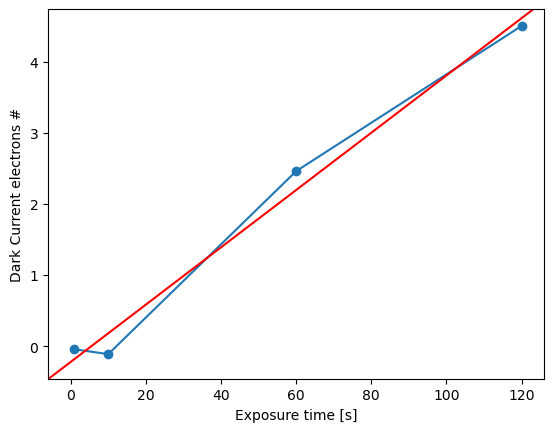

In [375]:
fig, ax = plt.subplots()
ax.plot(list(dark_stacked.keys()),[dark_stacked[i].mean() for i in dark_stacked.keys()],linestyle="-",marker="o")
plt.xlabel("Exposure time [s]")
plt.ylabel("Dark Current electrons #")
ax.axline((0, intercept), slope=slope, color='red', label='by slope')

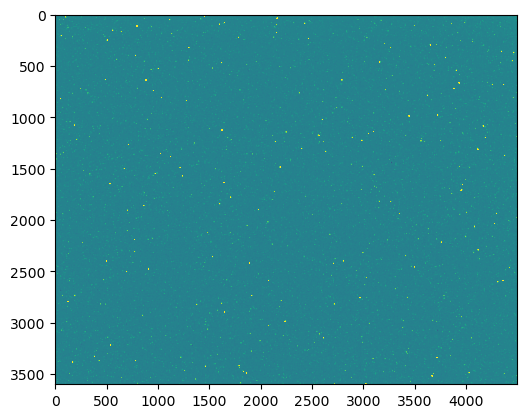

In [376]:
plt.imshow(dark_stacked[60],clim=[-20,30])

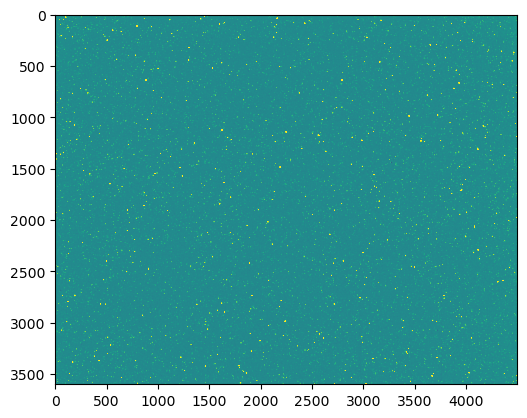

In [377]:

plt.imshow(dark_stacked[120],clim=[-20,30])

## Dark Current Pixelwise

Dark current is calculated per pixel, only the with count higher than the 0.999 quantile are considered (16k instead of 16M as they are reduced by a factor of 1000)

In [378]:
limit = np.quantile(dark_stacked[120], 0.999)
limit

124.57999999999998

In [379]:
lista_pixel=[]
if not os.path.exists("currents.npz"):
    currents = np.zeros((3599, 4499))
    c=0
    
    for i in range(currents.shape[0]):
        for j in range(currents.shape[1]):
            if dark_stacked[120][i][j] > limit:
                currents[i][j] = stats.linregress(list(dark_stacked.keys()), [dark_stacked[k][i][j] for k in dark_stacked.keys()])[0]
                lista_pixel.append((i,j))
                c+=1
    print(c)
    np.savez_compressed("currents.npz",currents)
else:
    currents=np.load("currents.npz")['arr_0']

In [380]:
# The dark current calculated on the first 160k brighter pixels is much higher than the one calculated on the whole sensor
currents[currents>0].mean()

5.289879239111844

In [381]:
#Choose a random pixel, among the most affected, and calculate the dark current for that pixel, than plot it (different results each run)
if lista_pixel:
    pix = random.choice(lista_pixel)
    current,intercept = stats.linregress(list(dark_stacked.keys()), [dark_stacked[k][pix[0]][pix[1]] for k in dark_stacked.keys()])[0:2]
    print(f"Pixel # {pix} has dark current:",current,"e/s")
    fig, ax = plt.subplots()
    ax.plot(list(dark_stacked.keys()),[dark_stacked[k][pix[0]][pix[1]] for k in dark_stacked.keys()],linestyle="-",marker="o")
    plt.xlabel("Exposure time [s]")
    plt.ylabel("Dark Current electrons #")
    ax.axline((0, intercept), slope=current, color='red', label='by slope')

## Dark current subtraction

In [382]:
expodict = {}
for img in processed_images.keys():
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

for img in processed_calibration.keys():
    data = fits.open("./dataM103/"+img)
    expodict[img] = data[0].header['EXPTIME']
    data.close()

In [383]:
processed_images_wo_dark = {}
for k in processed_images.keys():
    processed_images_wo_dark[k] = processed_images[k] - currents * expodict[k]

processed_calibration_wo_dark = {}
for k in processed_calibration.keys():
    processed_calibration_wo_dark[k] = processed_calibration[k] - currents * expodict[k]
    

In [384]:
#After this operation the dictionaries processed_images_wo_dark 
# and processed_calibration_wo_dark contains the images of M103 
# and the images of calibration stars with count in electrions, 
# bias subtracted, flat corrected and dark current removed

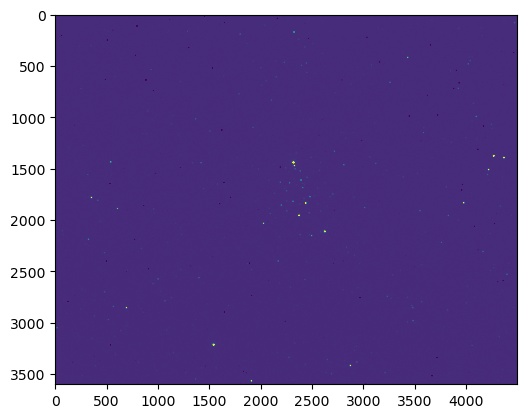

In [385]:
plt.imshow(processed_images_wo_dark['M103_003OIII300s.fit'],clim=[0,1000])

# Sky background

In [386]:
[i for i in processed_images_wo_dark.keys() if "Ha" in i]

['M103_003Ha300s.fit',
 'M103_002Ha300s.fit',
 'M103_004Ha300s.fit',
 'M103_001Ha300s.fit']

In [387]:
skybackground = {}
print('Sky background for target frames in e/s')
for fil in ['Ha','OIII','SII']:
    lst_stdskymean = []
    lst_stdskylevel = []
    lst_stdskyrms = []
    for k in [i for i in processed_images_wo_dark.keys() if fil in i]:
        stdskymean, stdskylevel, stdskyrms = (sigma_clipped_stats(processed_images_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean.append(stdskymean/expodict[k])
        lst_stdskylevel.append(stdskylevel/expodict[k])
        lst_stdskyrms.append(stdskyrms/expodict[k])

    sk_mean_fil = np.array(lst_stdskymean).mean()
    sk_lvl_fil  = np.array(lst_stdskylevel).mean()
    sk_rms_fil = np.array(lst_stdskyrms).mean()
    print(f'for {fil}: mean = {sk_mean_fil} median = {sk_lvl_fil} rms = {sk_rms_fil}')
    skybackground[fil] = {'mean':sk_mean_fil,'level':sk_lvl_fil,'rms':sk_rms_fil}

Sky background for target frames in e/s
for Ha: mean = 0.38124821825719246 median = 0.3806431820298374 rms = 0.056059634783903925
for OIII: mean = 0.4296589813509068 median = 0.42904843409320476 rms = 0.05773344805038252
for SII: mean = 0.3036904904146875 median = 0.30308828173602803 rms = 0.053304865646152264


In [388]:
skybackgroundcalib = {}
print('Sky background for calibration stars in e/s')
for fil in ['Ha','OIII','SII']:
    lst_stdskymean_calib = []
    lst_stdskylevel_calib = []
    lst_stdskyrms_calib = []
    for k in [i for i in processed_calibration_wo_dark.keys() if fil in i]:
        stdskymean_cal, stdskylevel_cal, stdskyrms_cal = (sigma_clipped_stats(processed_calibration_wo_dark[k], sigma=3, maxiters=20))
        lst_stdskymean_calib.append(stdskymean_cal/expodict[k])
        lst_stdskylevel_calib.append(stdskylevel_cal/expodict[k])
        lst_stdskyrms_calib.append(stdskyrms_cal/expodict[k])

    sk_mean_fil_calib = np.array(lst_stdskymean_calib).mean()
    sk_lvl_fil_calib  = np.array(lst_stdskylevel_calib).mean()
    sk_rms_fil_calib = np.array(lst_stdskyrms_calib).mean()
    print(f'for {fil}: mean = {sk_mean_fil_calib} median = {sk_lvl_fil_calib} rms = {sk_rms_fil_calib}')
    skybackgroundcalib[fil] = {'mean':sk_mean_fil_calib,'level':sk_lvl_fil_calib,'rms':sk_rms_fil_calib}

Sky background for calibration stars in e/s
for Ha: mean = 2.1202632655727034 median = 1.9429484667478312 rms = 24.174466147940024
for OIII: mean = 0.3608741306240888 median = 0.16118045821811464 rms = 24.157146691776518
for SII: mean = -0.5714915160076955 median = -0.7270265044321885 rms = 24.13931477001842


As target images were taken at higher exposition time compared to standard star frames, they are used to calculate sky background as sky background/bias (or dark current) ratio is greater

## Correct target images and standard star images by sky background

In [389]:
processed_images_wo_dark_wo_sky = {}
processed_calibration_wo_dark_wo_sky = {}
for k in processed_images_wo_dark.keys():
    if 'Ha' in k:
        processed_images_wo_dark_wo_sky[k] = processed_images_wo_dark[k] - skybackground['Ha']['mean']*expodict[k]
    elif 'OIII' in k:
        processed_images_wo_dark_wo_sky[k] = processed_images_wo_dark[k] - skybackground['OIII']['mean']*expodict[k]
    elif 'SII' in k:
        processed_images_wo_dark_wo_sky[k] = processed_images_wo_dark[k] - skybackground['SII']['mean']*expodict[k]

for k in processed_calibration_wo_dark.keys():
    if 'Ha' in k:
        processed_calibration_wo_dark_wo_sky[k] = processed_calibration_wo_dark[k] - skybackgroundcalib['Ha']['mean']*expodict[k]
    elif 'OIII' in k:
        processed_calibration_wo_dark_wo_sky[k] = processed_calibration_wo_dark[k] - skybackgroundcalib['OIII']['mean']*expodict[k]
    elif 'SII' in k:
        processed_calibration_wo_dark_wo_sky[k] = processed_calibration_wo_dark[k] - skybackgroundcalib['SII']['mean']*expodict[k]

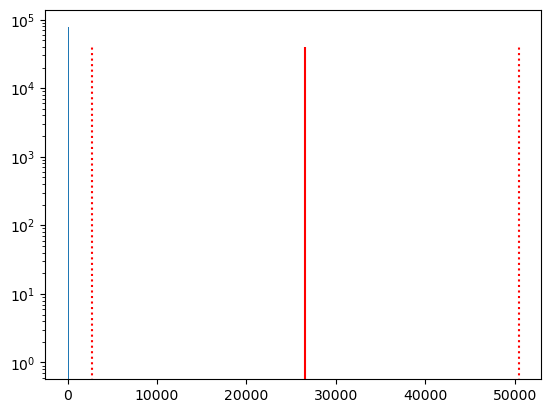

In [390]:
plt.hist(processed_images_wo_dark[list(processed_images_wo_dark.keys())[3]].flatten(),bins=1000,range=[0,200])
plt.vlines(stdskymean*300,ymin = 0,ymax=40000,color='red',label='stdskylevel')
plt.vlines(stdskymean*300+5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.vlines(stdskymean*300-5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.yscale('log')

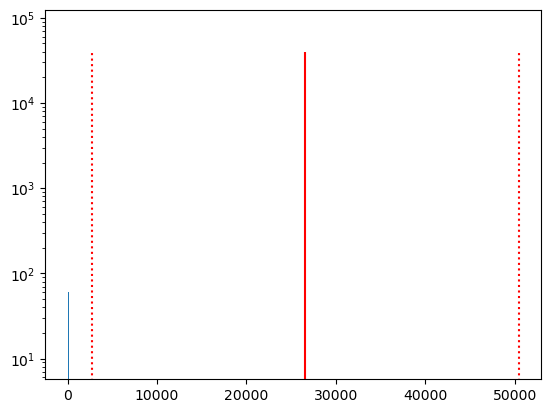

In [391]:
plt.hist(processed_images_wo_dark_wo_sky[list(processed_images_wo_dark.keys())[3]].flatten(),bins=1000,range=[0,200])
plt.vlines(stdskymean*300,ymin = 0,ymax=40000,color='red',label='stdskylevel')
plt.vlines(stdskymean*300+5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.vlines(stdskymean*300-5.*stdskyrms*300,ymin = 0,ymax=40000,linestyles=":",color='red')
plt.yscale('log')

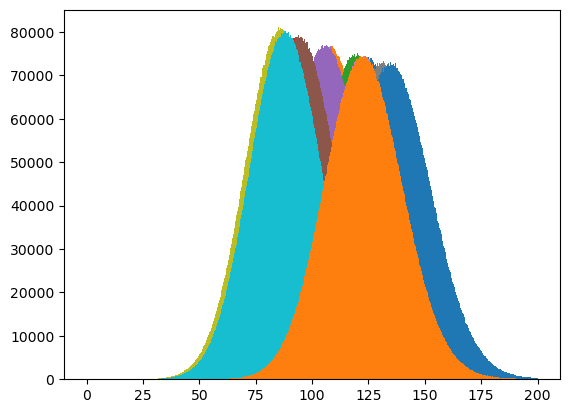

In [392]:
for k in processed_images_wo_dark.keys():
    plt.hist(processed_images_wo_dark[k].flatten(),bins=1000,range=[0,200])

# Standard star

## UniMiB filters creation

In [393]:
#using speclite modulus from https://speclite.readthedocs.io/en/latest/
from speclite import filters

In [394]:
#Code to create .ECSV filters to be used with speclite modulus
reprocess = False
if reprocess:
    Ha_filter_trans = pd.read_csv("./Halpha_3p5nm_Ultra-Narrowband.txt",sep=r"\s+")
    OIII_filter_trans = pd.read_csv("./OIII_4nm_Ultra-Narrowband.txt",sep=r"\s+")
    SII_filter_trans = pd.read_csv("./SII_4nm_Ultra-Narrowband.txt",sep=r"\s+")
    Ha_filter_trans['wave_A']=round(Ha_filter_trans['#Wave_nm']*10,2)
    Ha_filter_trans['T']=round(Ha_filter_trans['Transmission']/100,5)
    OIII_filter_trans['wave_A']=round(OIII_filter_trans['#Wave_nm']*10,2)
    OIII_filter_trans['T']=round(OIII_filter_trans['Transmission']/100,5)
    SII_filter_trans['wave_A']=round(SII_filter_trans['#Wave_nm']*10,2)
    SII_filter_trans['T']=round(SII_filter_trans['Transmission']/100,5)
    Ha_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    OIII_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    SII_filter_trans.drop(columns=['#Wave_nm','Transmission'],inplace=True)
    Ha_filter_trans.to_csv("Ha_filter.ecsv",sep=" ",header=None,index=None)
    OIII_filter_trans.to_csv("OIII_filter_trans.ecsv",sep=" ",header=None,index=None)
    SII_filter_trans.to_csv("SII_filter_trans.ecsv",sep=" ",header=None,index=None)
    #text to prepend to filters to transform txt file into ECSV properly with metadata
    text_to_prepend_Ha = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: Ha}
    # - {group_name: UniMiB}
    wavelength response"""
    text_to_prepend_OIII = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: OIII}
    # - {group_name: UniMiB}
    wavelength response"""
    text_to_prepend_SII = """# %ECSV 1.0
    # ---
    # datatype:
    # - {name: wavelength, unit: Angstrom, datatype: float64}
    # - {name: response, datatype: float64}
    # meta: !!omap
    # - {band_name: SII}
    # - {group_name: UniMiB}
    wavelength response"""
    line_prepender('./Ha_filter.ecsv',text_to_prepend_Ha)
    line_prepender('./OIII_filter_trans.ecsv',text_to_prepend_OIII)
    line_prepender('./SII_filter_trans.ecsv',text_to_prepend_SII)

In [395]:
Bico_filters = filters.load_filters('Ha_filter.ecsv','OIII_filter_trans.ecsv','SII_filter_trans.ecsv')

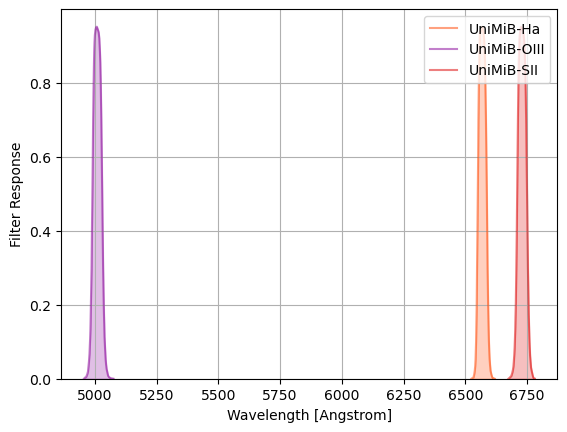

In [396]:
filters.plot_filters(Bico_filters)

In [397]:
Bico_filters.effective_wavelengths

<Quantity [6569.05793053, 5009.15256507, 6730.10447145] Angstrom>

## Standard star magnitude through our filters

In [398]:
HD3360_emissions = pd.read_csv("./fhr153.dat.txt",sep=r"\s+",header=None,names=["wavelength_A","flux_ergs/cm/cm/s/A*10**16","flux_milli_Jy"])
wlen_HD3360 = HD3360_emissions['wavelength_A'].to_numpy() * u.Angstrom 
flux_HD3360 = HD3360_emissions['flux_ergs/cm/cm/s/A*10**16'].to_numpy() * u.erg / (u.cm**2 * u.s * u.Angstrom *10**16)

In [399]:
wlen_HD3360

<Quantity [  925.52  ,   934.78  ,   944.04  , ..., 11969.75  , 11989.7305,
           12009.7402] Angstrom>

In [400]:
flux_HD3360

<Quantity [4.7773e-10, 1.2446e-09, 2.2219e-09, ..., 8.1259e-12, 8.0799e-12,
           8.0340e-12] erg / (Angstrom cm2 s)>

In [401]:
#AB magnitudes convolving HD3360 flux through UniMiB filters
mag_HD3360_unimib = Bico_filters.get_ab_magnitudes(flux_HD3360,wlen_HD3360).as_array()
print(f"HD3360 theoretically shows:\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-Ha']} through our Ha filter\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-OIII']} through our OIII filter\n\
    AB Magnitude {mag_HD3360_unimib['UniMiB-SII']} through our SII filter")

HD3360 theoretically shows:
    AB Magnitude [4.02077374] through our Ha filter
    AB Magnitude [3.49282932] through our OIII filter
    AB Magnitude [3.98019712] through our SII filter


## Experimental standard star magnitude

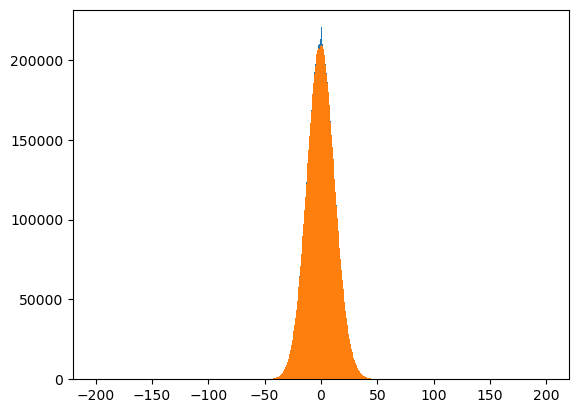

In [402]:
for k in list(processed_calibration_wo_dark_wo_sky.keys())[4:6]:
    plt.hist(processed_calibration_wo_dark_wo_sky[k].flatten(),bins=1000,range=[-200,200])

In [403]:
processed_calibration_wo_dark_wo_sky.keys()

dict_keys(['HD3360_003Ha.fit', 'HD3360_003OIII.fit', 'HD3360_001Ha.fit', 'HD3360_002OIII.fit', 'HD3360_003SII.fit', 'HD3360_002Ha.fit', 'HD3360_001OIII.fit', 'HD3360_001SII.fit', 'HD3360_002SII.fit'])

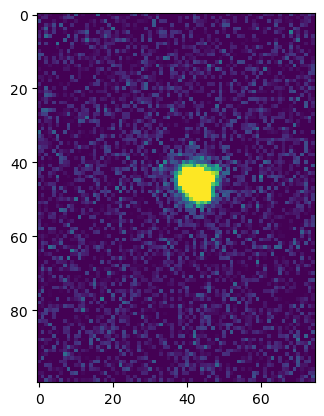

In [404]:

cutoutHa = processed_calibration_wo_dark_wo_sky['HD3360_001Ha.fit'][1685:1785,2275:2350]
cutoutOIII = processed_calibration_wo_dark_wo_sky['HD3360_003OIII.fit'][1685:1785,2275:2350]
cutoutSII = processed_calibration_wo_dark_wo_sky['HD3360_003SII.fit'][1685:1785,2275:2350]
plt.imshow(cutoutHa,clim=[0,100])

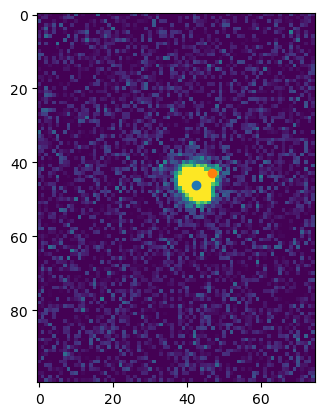

In [405]:
plt.clf()
plt.imshow(cutoutHa,clim=[0,100])
xc1Ha,yc1Ha = photutils.centroids.centroid_com(cutoutHa)
xc2Ha,yc2Ha = photutils.centroids.centroid_2dg(cutoutHa)
xc1OIII,yc1OIII = photutils.centroids.centroid_com(cutoutOIII)
xc2OIII,yc2OIII = photutils.centroids.centroid_2dg(cutoutOIII)
xc1SII,yc1SII = photutils.centroids.centroid_com(cutoutSII)
xc2SII,yc2SII = photutils.centroids.centroid_2dg(cutoutSII)
plt.scatter([xc1Ha],[yc1Ha])
plt.scatter([xc2Ha],[yc2Ha])

FWHM  1.5064822271561928


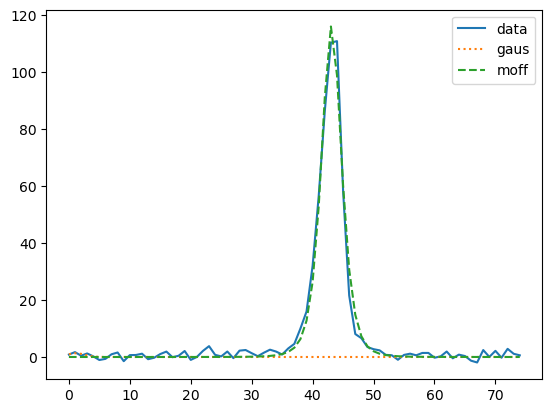

In [406]:
xplane = np.nanmean(cutoutHa,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

moff = models.Moffat1D(amplitude=20,x_0=40, gamma=1, alpha=1)
xaxis = np.arange(len(xplane))
moffit = fit_g(moff, xaxis, xplane)
plt.plot(xaxis,moffit(xaxis),linestyle="--",label='moff')
plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM ",2.355*gausfit.stddev*pixtoasc)


In [407]:
2.355*gausfit.stddev*3

10.271469730610406

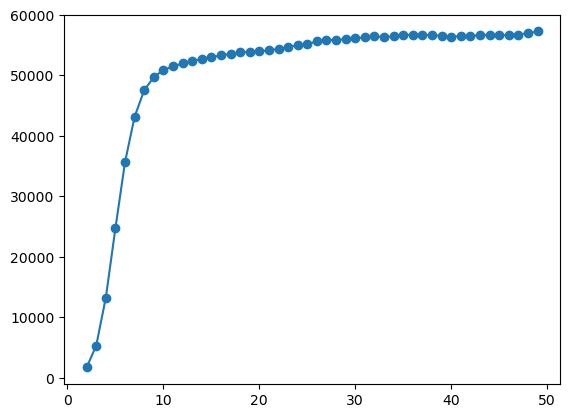

In [408]:
positions = [(xc2Ha,yc2Ha)]
radii = np.arange(2,50,1)
phot = np.zeros(len(radii))

for ii,rr in enumerate(radii):
    aper = photutils.CircularAperture(positions, r=rr)
    phot_table = photutils.aperture_photometry(cutoutHa, aper)
    phot[ii] = phot_table['aperture_sum']
plt.clf()
plt.scatter(radii,phot)
plt.plot(radii,phot)


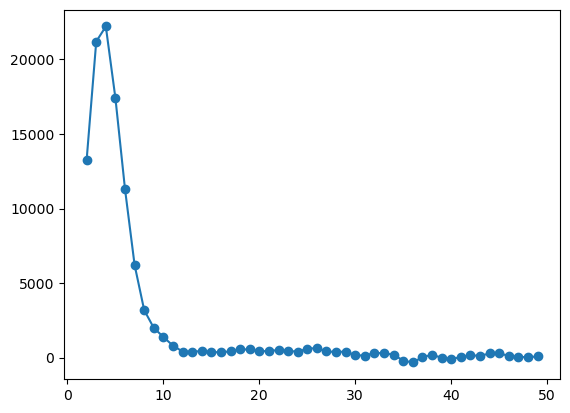

In [416]:
for ii,rr in enumerate(radii):
    aperring = photutils.aperture.CircularAnnulus(positions, rr-1, rr+1)
    #aper = photutils.CircularAperture(positions, r=rr)
    phot_table = photutils.aperture_photometry(cutoutHa, aperring)
    phot[ii] = phot_table['aperture_sum']
plt.clf()
plt.scatter(radii,phot)
plt.plot(radii,phot)


In [417]:
positions

[42.83273622416552, 42.159399889317385]

In [418]:
cum_lum=[]
for f in [(xc2Ha,yc2Ha,cutoutHa),(xc2OIII,yc2OIII,cutoutOIII),(xc2SII,yc2SII,cutoutSII)]:
    positions = [f[0],f[1]]
    apermax = photutils.CircularAperture(positions, r=40)
    cum_lum.append(photutils.aperture_photometry(f[2], apermax)['aperture_sum'])
print(cum_lum)

[<Column name='aperture_sum' dtype='float64' length=1>
56438.45194206626, <Column name='aperture_sum' dtype='float64' length=1>
113141.3010717191, <Column name='aperture_sum' dtype='float64' length=1>
65983.00151863944]


In [419]:
f_freq_stand_Ha=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-Ha']/2.5)
f_freq_stand_OIII=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-OIII']/2.5)
f_freq_stand_SII=3631*10**(-23)*10**(-mag_HD3360_unimib['UniMiB-SII']/2.5)
f_lambda_stand_Ha = f_freq_stand_Ha*C/lamb**2
f_lambda_stand_OIII = f_freq_stand_OIII*C/lamb**2
f_lambda_stand_SII = f_freq_stand_SII*C/lamb**2
print(f"zero point for Ha is: {math.log10(cum_lum[0]/f_lambda_stand_Ha)}\n\
zero point for OIII is: {math.log10(cum_lum[1]/f_lambda_stand_OIII)}\n\
zero point for SII is: {math.log10(cum_lum[2]/f_lambda_stand_SII)}\n\
log10([e/s]/[erg/s/cm^2/A])")

zero point for Ha is: 14.803763015197008
zero point for OIII is: 14.89463132327591
zero point for SII is: 14.855389342935366
log10([e/s]/[erg/s/cm^2/A])


## Local background subtraction

In [438]:
bkg_mean=[]
bkg_std=[]
for f in [(xc2Ha,yc2Ha,cutoutHa),(xc2OIII,yc2OIII,cutoutOIII),(xc2SII,yc2SII,cutoutSII)]:
    positions = [f[0],f[1]]
    annulus_aperture = photutils.aperture.CircularAnnulus(positions, r_in=40, r_out=60)
    aperstats = photutils.aperture.ApertureStats(f[2], annulus_aperture)
    bkg_mean.append(aperstats.mean)
    bkg_std.append(aperstats.std)
print(bkg_mean)  

[0.47857544159116105, -0.22962054501337742, -0.22372678504076213]


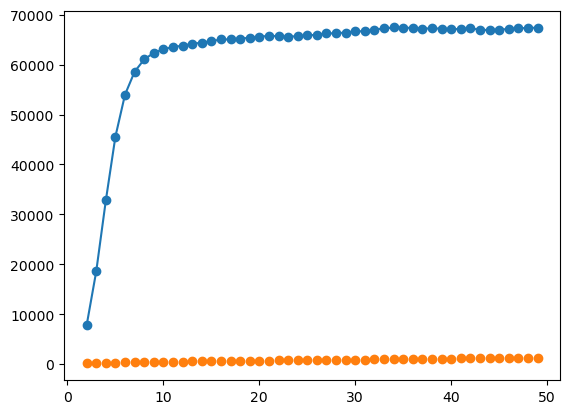

In [450]:
cutout_wo_localBK_Ha = cutoutHa - bkg_mean[0]
cutout_wo_localBK_OIII = cutoutOIII - bkg_mean[1]
cutout_wo_localBK_SII = cutoutSII - bkg_mean[2]
new_cumulative_lum = []
for e,f in enumerate([(xc2Ha,yc2Ha,cutout_wo_localBK_Ha),(xc2OIII,yc2OIII,cutout_wo_localBK_OIII),(xc2SII,yc2SII,cutout_wo_localBK_SII)]):
    for ii,rr in enumerate(radii):
        aper = photutils.CircularAperture((f[0],f[1]), r=rr)
        phot_table = photutils.aperture_photometry(f[2], aper)
        phot[ii] = phot_table['aperture_sum']
    new_cumulative_lum.append(phot_table['aperture_sum'])
    plt.clf()
    plt.scatter(radii,phot)
    plt.scatter(radii,np.sqrt(phot)+bkg_std[e]*np.sqrt(np.pi)*radii)
    plt.plot(radii,phot)



In [154]:
print(new_cumulative_lum)

[<Column name='aperture_sum' dtype='float64' length=1>
54340.10293427262, <Column name='aperture_sum' dtype='float64' length=1>
114144.7506315294, <Column name='aperture_sum' dtype='float64' length=1>
67402.75340981726]


In [155]:
new_cumulative_lum

print(f"Zero points with local background subtracted:\nzero point for Ha is: {math.log10(new_cumulative_lum[0]/f_lambda_stand_Ha)}\n\
zero point for OIII is: {math.log10(new_cumulative_lum[1]/f_lambda_stand_OIII)}\n\
zero point for SII is: {math.log10(new_cumulative_lum[2]/f_lambda_stand_SII)}\n\
log10([e/s]/[erg/s/cm^2/A])")

Zero points with local background subtracted:
zero point for Ha is: 14.787308379022658
zero point for OIII is: 14.898466098308342
zero point for SII is: 14.864634913411868
log10([e/s]/[erg/s/cm^2/A])


# Frames aligning and stacking

In [156]:
#Using astroalign library imported as "asa"

In [157]:
listaimgs = list(processed_images_wo_dark_wo_sky.keys())
listaHa=[i for i in listaimgs if 'Ha' in i]
listaOIII=[i for i in listaimgs if 'OIII' in i]
listaSII=[i for i in listaimgs if 'SII' in i]
processed_images_wo_drk_sky_align = {}
processed_images_wo_drk_sky_align['Ha'],processed_images_wo_drk_sky_align['OIII'],processed_images_wo_drk_sky_align['SII'] = {},{},{}
processed_images_wo_drk_sky_align['Ha'][listaHa[0]] = processed_images_wo_dark_wo_sky[listaHa[0]]
processed_images_wo_drk_sky_align['OIII'][listaOIII[0]] = processed_images_wo_dark_wo_sky[listaOIII[0]]
processed_images_wo_drk_sky_align['SII'][listaSII[0]] = processed_images_wo_dark_wo_sky[listaSII[0]]


In [158]:
for img in listaHa[1:]:
    processed_images_wo_drk_sky_align['Ha'][img] = asa.register(processed_images_wo_dark_wo_sky[img],processed_images_wo_drk_sky_align['Ha'][listaHa[0]])[0]
for img in listaOIII[1:]:
    processed_images_wo_drk_sky_align['OIII'][img] = asa.register(processed_images_wo_dark_wo_sky[img],processed_images_wo_drk_sky_align['OIII'][listaOIII[0]])[0]
for img in listaSII[1:]:
    processed_images_wo_drk_sky_align['SII'][img] = asa.register(processed_images_wo_dark_wo_sky[img],processed_images_wo_drk_sky_align['SII'][listaSII[0]])[0]

In [159]:
stacked_aligned_images = {}
stacked_aligned_images['Ha']=np.zeros((3599,4499))
stacked_aligned_images['OIII']=np.zeros((3599,4499))
stacked_aligned_images['SII']=np.zeros((3599,4499))
for k in processed_images_wo_drk_sky_align.keys():
    for img in processed_images_wo_drk_sky_align[k].keys():
        stacked_aligned_images[k] = np.add(stacked_aligned_images[k],processed_images_wo_drk_sky_align[k][img]) 
    stacked_aligned_images[k]=stacked_aligned_images[k]/len(processed_images_wo_drk_sky_align[k].keys())


stacked_aligned_images['OIII'] = asa.register(stacked_aligned_images['OIII'],stacked_aligned_images['Ha'])[0]
stacked_aligned_images['SII'] = asa.register(stacked_aligned_images['SII'],stacked_aligned_images['Ha'])[0]


In [160]:
#verify correct stacking of aligned images
pixel=(random.randint(0,3599),random.randint(0,4499))
print(pixel)
for k in processed_images_wo_drk_sky_align.keys():
    print("\n",k)
    for img in processed_images_wo_drk_sky_align[k].keys():
        print(processed_images_wo_drk_sky_align[k][img][pixel])
    print("stacked sum =",stacked_aligned_images[k][pixel])

(1303, 3906)

 Ha
-6.3133935024990535
2.716758101265672
-30.431041787813182
12.135876583905068
stacked sum = -5.472950151285374

 OIII
-8.819397937781758
-6.136117366970727
26.695020976555913
0.08182202792067991
stacked sum = 0.2872396772445776

 SII
9.821678896607196
-4.233601847146916
7.292369547997677
-0.7048590738680814
stacked sum = 0.7621807568422823


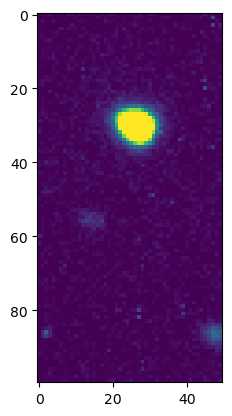

In [161]:
plt.clf()
plt.imshow(stacked_aligned_images['Ha'][2000:2100,2000:2050],clim=[0,300])

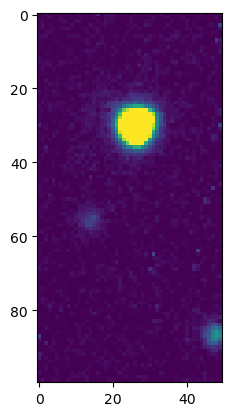

In [162]:
plt.clf()
plt.imshow(stacked_aligned_images['SII'][2000:2100,2000:2050],clim=[0,300])

TODO: \
verify astroalign interpolation

In [163]:
transf, (source_list, target_list) = asa.find_transform(processed_images_wo_drk_sky_align['Ha'][listaHa[0]], processed_images_wo_dark_wo_sky[listaHa[1]])
transf.rotation

0.00039010829442243615

In [164]:
transf.translation

array([  9.50710914, -31.82034289])

# Photometry

## Finding FWHM for few stars

In [198]:
fwhm = {"Ha":[],"OIII":[],"SII":[]}

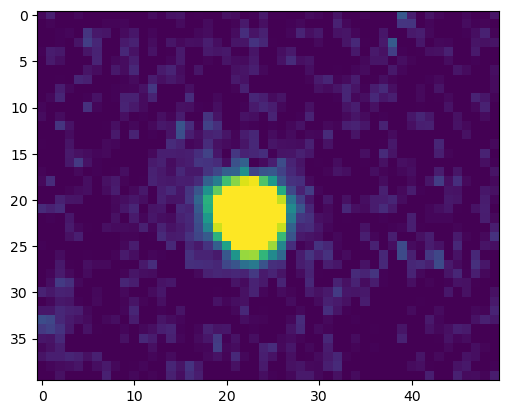

In [199]:
plt.imshow(stacked_aligned_images['OIII'][2120:2160,2360:2410],clim=[0,100])

In [200]:
target_cutout_Ha = stacked_aligned_images['Ha'][2120:2160,2360:2410]
target_cutout_OIII = stacked_aligned_images['OIII'][2120:2160,2360:2410]
target_cutout_SII = stacked_aligned_images['SII'][2120:2160,2360:2410]

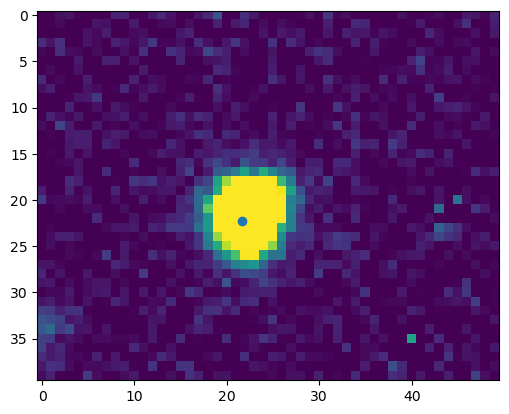

In [201]:
plt.clf()
plt.imshow(target_cutout_SII,clim=[0,100])
xc2Ha,yc2Ha = photutils.centroids.centroid_2dg(target_cutout_Ha)
xc2OIII,yc2OIII = photutils.centroids.centroid_2dg(target_cutout_OIII)
xc2SII,yc2SII = photutils.centroids.centroid_2dg(target_cutout_SII)
plt.scatter([xc2OIII],[yc2OIII])

FWHM_Ha  2.539624645001662


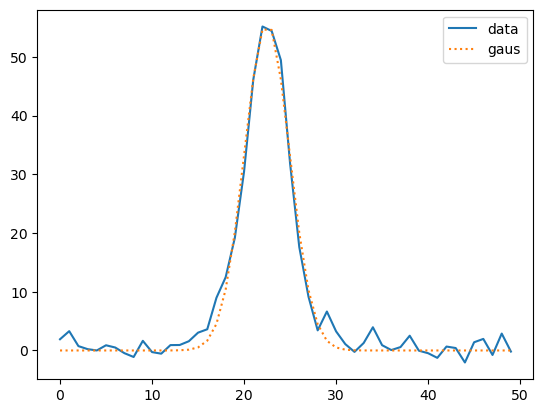

In [202]:
xplane = np.nanmean(target_cutout_Ha,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4,mean=20)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_Ha ",2.355*gausfit.stddev*pixtoasc)
fwhm['Ha'].append(2.355*gausfit.stddev*pixtoasc)

FWHM_OIII  1.9417263696868092


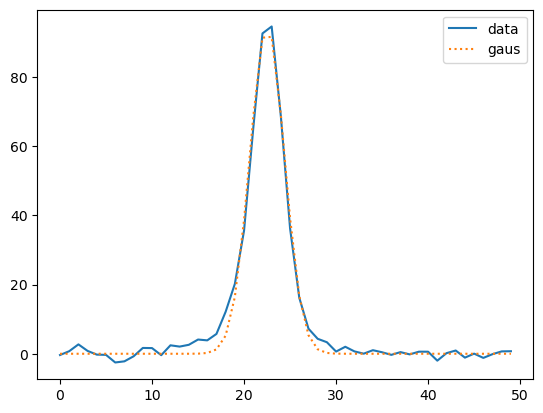

In [203]:
xplane = np.nanmean(target_cutout_OIII,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=60, stddev=4,mean=25)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_OIII ",2.355*gausfit.stddev*pixtoasc)
fwhm['OIII'].append(2.355*gausfit.stddev*pixtoasc)

FWHM_SII  2.1925185664628657


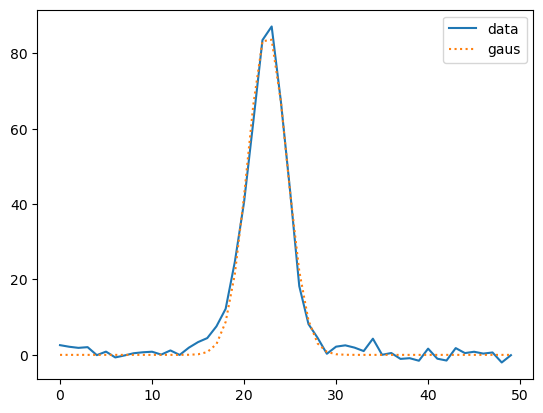

In [204]:
xplane = np.nanmean(target_cutout_SII,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4,mean=25)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_SII ",2.355*gausfit.stddev*pixtoasc)
fwhm['SII'].append(2.355*gausfit.stddev*pixtoasc)

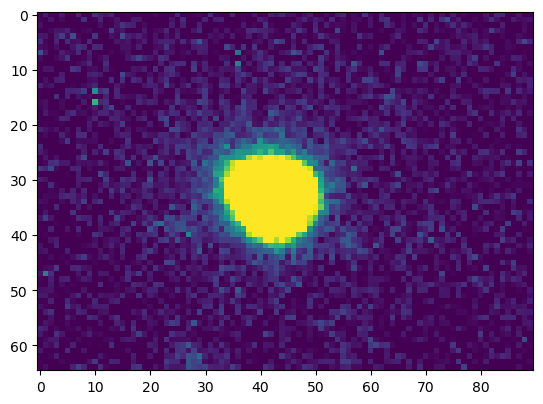

In [205]:
plt.imshow(stacked_aligned_images['Ha'][1920:1985,2330:2420],clim=[0,100])

In [206]:
target_cutout_Ha_2 = stacked_aligned_images['Ha'][1920:1985,2330:2420]
target_cutout_OIII_2 = stacked_aligned_images['OIII'][1920:1985,2330:2420]
target_cutout_SII_2 = stacked_aligned_images['SII'][1920:1985,2330:2420]

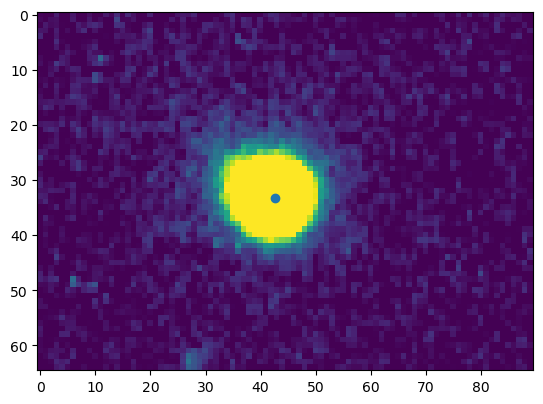

In [207]:
plt.clf()
plt.imshow(target_cutout_OIII_2,clim=[0,100])
xc3Ha,yc3Ha = photutils.centroids.centroid_2dg(target_cutout_Ha_2)
xc3OIII,yc3OIII = photutils.centroids.centroid_2dg(target_cutout_OIII_2)
xc3SII,yc3SII = photutils.centroids.centroid_2dg(target_cutout_SII_2)
plt.scatter([xc3OIII],[yc3OIII])

FWHM  2.5016963377385637


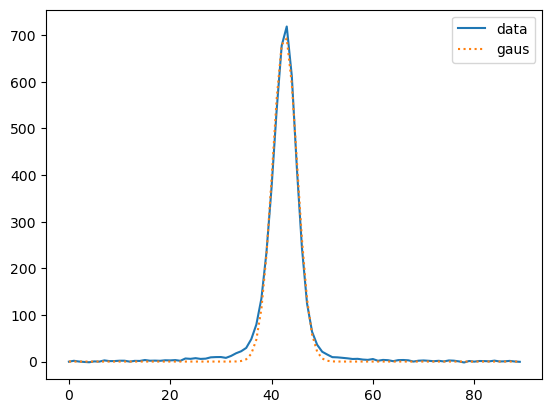

In [208]:
xplane = np.nanmean(target_cutout_Ha_2,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM ",2.355*gausfit.stddev*pixtoasc)
fwhm['Ha'].append(2.355*gausfit.stddev*pixtoasc)

FWHM_OIII  2.0139258018639317


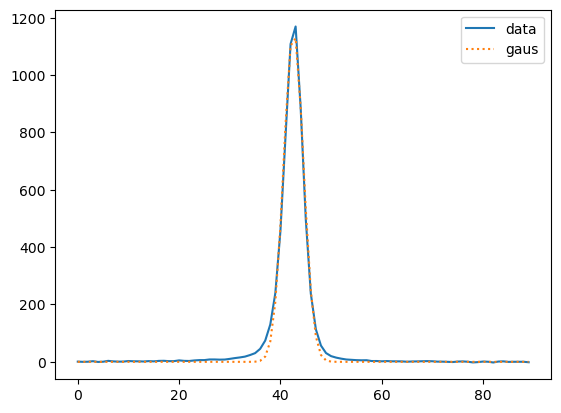

In [316]:
xplane = np.nanmean(target_cutout_OIII_2,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_OIII ",2.355*gausfit.stddev*pixtoasc)
fwhm['OIII'].append(2.355*gausfit.stddev*pixtoasc)

FWHM_SII  2.1949402131544273


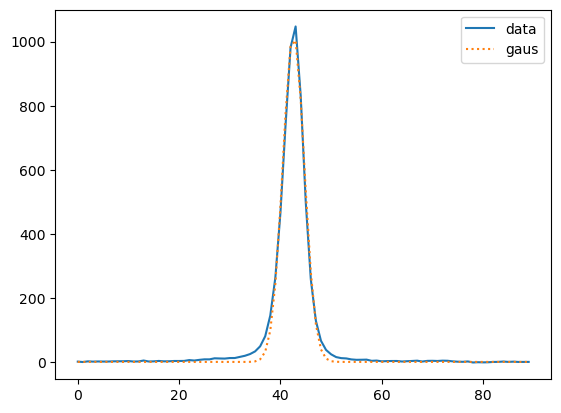

In [317]:
xplane = np.nanmean(target_cutout_SII_2,axis=0)
plt.clf()
plt.plot(xplane,label='data')
gaus = models.Gaussian1D(amplitude=40, stddev=4)
xaxis = np.arange(len(xplane))
fit_g = fitting.LevMarLSQFitter()
gausfit = fit_g(gaus, xaxis, xplane)
plt.plot(xaxis,gausfit(xaxis),linestyle=":",label='gaus')

plt.legend()

xybin = 2
pixtoasc=0.44
print("FWHM_SII ",2.355*gausfit.stddev*pixtoasc)
fwhm['SII'].append(2.355*gausfit.stddev*pixtoasc)

In [318]:
fwhm

{'Ha': [2.539624645001662, 2.5016963377385637],
 'OIII': [1.9417263696868092, 2.0139258018639317, 2.0139258018639317],
 'SII': [2.1925185664628657, 2.1949402131544273, 2.1949402131544273]}

In [319]:
si=5
thresholdHa = stacked_aligned_images['Ha'].std()*si
thresholdOIII = stacked_aligned_images['OIII'].std()*si
thresholdSII = stacked_aligned_images['SII'].std()*si
print(f"Thresholds: Ha={thresholdHa}, OIII={thresholdOIII}, SII={thresholdSII}")

Thresholds: Ha=413.90877342181125, OIII=424.30688103314543, SII=494.292049418741


In [320]:
mean(fwhm['Ha'])

2.520660491370113

In [321]:
HaFinder=photutils.detection.DAOStarFinder(thresholdHa, mean(fwhm['Ha']))
OIIIFinder=photutils.detection.DAOStarFinder(thresholdOIII, mean(fwhm['OIII']))
SIIFinder=photutils.detection.DAOStarFinder(thresholdSII, mean(fwhm['SII']))

In [322]:
HaTable = HaFinder(stacked_aligned_images['Ha'])
OIIITable = OIIIFinder(stacked_aligned_images['OIII'])
SIITable = SIIFinder(stacked_aligned_images['SII'])

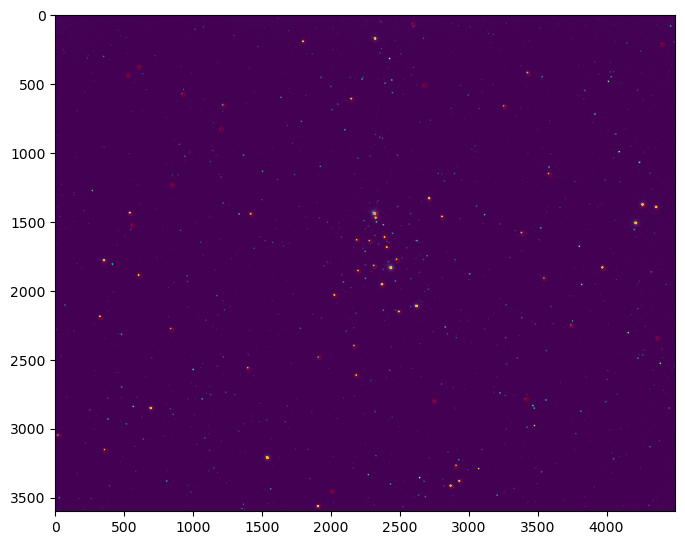

In [331]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.imshow(stacked_aligned_images['Ha'],clim=[0,300])
plt.scatter(HaTable['xcentroid'],HaTable['ycentroid'],color='red',s=10.3,alpha=0.15)
fig.savefig(f'stacked_Ha-sigma{si}.png', dpi=300)

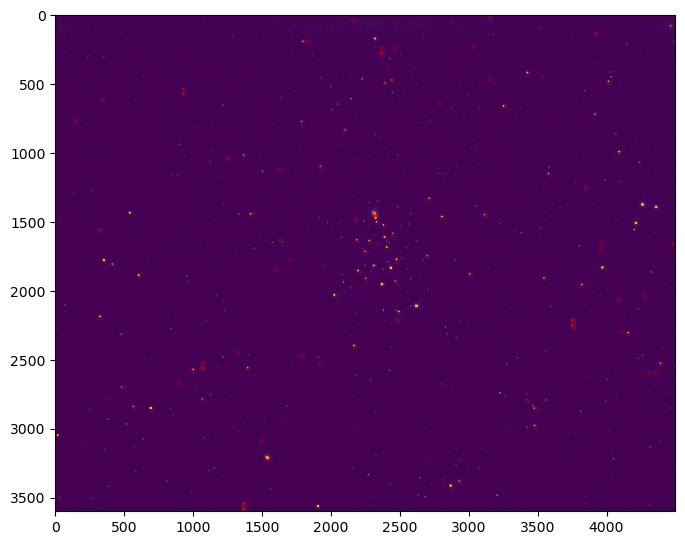

In [324]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.imshow(stacked_aligned_images['OIII'],clim=[0,300])
plt.scatter(OIIITable['xcentroid'],OIIITable['ycentroid'],color='red',s=10.3,alpha=0.15)
fig.savefig(f'stacked_OIII-sigma{si}.png', dpi=300)

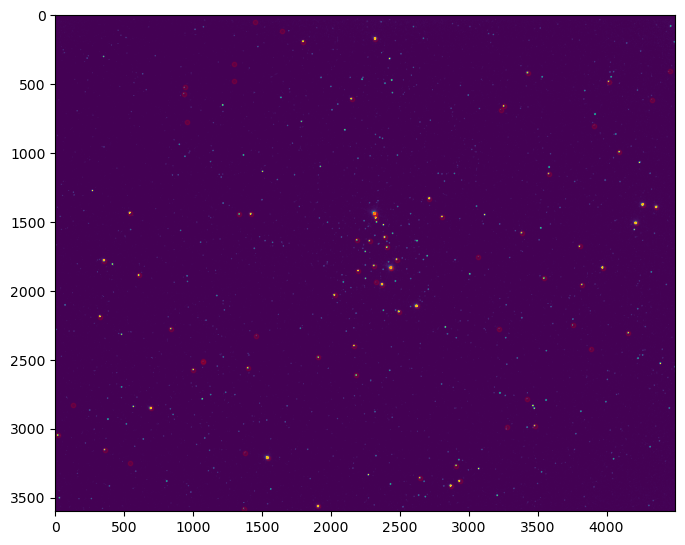

In [325]:
fig = plt.gcf()
fig.set_size_inches(8, 8)
plt.imshow(stacked_aligned_images['SII'],clim=[0,300])
plt.scatter(SIITable['xcentroid'],SIITable['ycentroid'],color='red',s=10.3,alpha=0.15)
fig.savefig(f'stacked_SII-sigma{si}.png', dpi=300)

In [326]:
HaTable

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2593.0303864133202,63.55977072655067,0.6819927710193436,-0.05536532547152282,-0.037813380664978274,25,0.0,537.6764137470634,1.2166818361271068,-0.21294256127057815
2,2323.068905229897,169.79749079582314,0.4853188546331011,0.280735366199057,-0.2799126113321199,25,0.0,13057.819275544334,15.107313251035876,-2.9479680860624624
3,1799.2305399047348,189.45319891079313,0.5067677906414129,0.4160013812323965,-0.32449536343490415,25,0.0,1993.1698662622066,2.2405241707185923,-0.8758740835807964
4,4399.182165948253,205.61548487065826,0.9139134997183817,0.12633663607370307,0.29663368308758514,25,0.0,494.7570332504172,1.0002474345430121,-0.00026861541066065955
5,608.2321342800502,374.2846492840943,0.6305948057175935,0.21697787884745737,-0.0037805801769428453,25,0.0,582.1600604148181,1.4379412111783927,-0.3943528267605304
6,3428.0216787456807,416.78329563700385,0.4766111501771947,0.21282441442134312,-0.16743389811668583,25,0.0,2029.5773119196317,2.1887693765378167,-0.850500009477704
7,529.0823816434028,435.47797720757717,0.9373363932413673,0.21910321645472305,0.38078197395246854,25,0.0,626.5919291652958,1.2550480276872258,-0.2466508638662274
8,2675.540027845242,505.63934170744704,0.8534719076737409,0.20458345305577827,-0.2341962638817104,25,0.0,614.9508322012272,1.3260907536068787,-0.306433117189174
9,923.7545288573666,571.5536506991822,0.9339240341519904,-0.15207284187673026,0.2111229428535425,25,0.0,1869.9135588835745,3.8802435599275826,-1.472147466957638


In [327]:
HaTable[HaTable['flux']>10]

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
2,2323.068905229897,169.79749079582314,0.4853188546331011,0.280735366199057,-0.2799126113321199,25,0.0,13057.819275544334,15.107313251035876,-2.9479680860624624
17,4263.287032773171,1374.363847643274,0.4888196880208362,0.19425383924421413,-0.2958293575366878,25,0.0,14598.02072465065,13.993265271838268,-2.8647976679443072
20,2317.8468444208397,1438.379285941438,0.4680294583886643,0.1792789840515353,-0.42966006224571274,25,0.0,39204.89059164802,33.950524310097954,-3.8271162140835746
21,2318.2091685903692,1438.9163567977137,0.5824618311788213,0.1162752307161229,-0.18056221677822779,25,0.0,36942.24495313346,34.09458539033976,-3.8317135338586246
25,4214.056852188207,1507.9000669584489,0.4958471553086395,0.1684649289084154,-0.11032097430929418,25,0.0,22818.261694514087,22.056022153547907,-3.3588179732818766
36,2436.9761403263806,1833.1447544718926,0.48429480215836285,0.3411807018809201,-0.4403760560444757,25,0.0,36831.012571463456,34.93012067056261,-3.858000214914969
40,2372.6984953352003,1953.200546275359,0.502439641959101,0.2421850211556895,-0.24025091396812862,25,0.0,9323.34770660604,10.42661447162714,-2.5453582890502324
42,2622.466788680864,2110.0510594898724,0.5042172179593502,0.2168776269479872,-0.23349487625683685,25,0.0,19709.801606417368,21.39027511306953,-3.3255409258186797
54,694.1833369825351,2851.3858921345486,0.4790798701074232,0.5138706114986943,-0.29029213403647186,25,0.0,8723.517603757831,10.029670057158988,-2.503216616022608
